In [1]:
# add folders to working path

In [2]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

CPU times: user 144 µs, sys: 171 µs, total: 315 µs
Wall time: 162 µs


# Overview

In the following notebook we compute the Poincaré Map of the three-dimensional, steady ABC-flow. The notebook is structured as follows:

1. Define analytic velocity field of the three-dimensional solution of the Euler equations, the steady and spatially periodic Arnold-Beltrami-Childress (ABC) flow:
\begin{equation}
\begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \\ \dot{z}(t) \end{pmatrix} = \begin{pmatrix} u \\ v \\ w \end{pmatrix} = \begin{pmatrix} \sqrt{3}\sin(z)+\cos(y) \\ \sqrt{2}\sin(x) + \sqrt{3}\cos(z) \\ \sin(y)+\sqrt{2}\cos(x) \end{pmatrix}, \quad (x,y,z) \in [0, 2\pi]^3
\label{eq: periodicABC}
\end{equation}
<br />
2. Define computational parameters.
 <br />
3. Define spatio-temporal domain.
 <br />

# Analytic velocity field

Here we define the spatially periodic and steady three dimensional ABC-velocity field.

In [3]:
import numpy as np
from math import sqrt

def velocity(x, y, z):

    u = sqrt(3)*np.sin(z)+np.cos(y)
    v = sqrt(2)*np.sin(x)+sqrt(3)*np.cos(z)
    w = np.sin(y)+sqrt(2)*np.cos(x)
    
    return np.array([u, v, w])

def dudx(x, y, z):
    return 0*x.copy()
def dudy(x, y, z):
    return -np.sin(y)
def dudz(x, y, z):
    return sqrt(3)*np.cos(z)

def dvdx(x, y, z):
    return sqrt(2)*np.cos(x)
def dvdy(x, y, z):
    return 0*x.copy()
def dvdz(x, y, z):
    return -sqrt(3)*np.sin(z)

def dwdx(x, y, z):
    return -sqrt(2)*np.sin(x)
def dwdy(x, y, z):
    return np.cos(y)
def dwdz(x, y, z):
    return 0*x.copy()

# Computational parameters

Here we define the computational parameters and the analytic velocity field.

In [4]:
# import numpy
import numpy as np

# import math tools
from math import sqrt, pi

# number of cores to be used for parallel computing
Ncores = 15

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [5]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 10 # float

# Time step-size (in days)
dt = 0.1 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

CPU times: user 26 µs, sys: 6 µs, total: 32 µs
Wall time: 34.1 µs


# Compute Cauchy-Green strain tensor

In [6]:
def integration_dDF_dt(time, x):
    
    # reshape x
    x = x.reshape(3, -1)
    
    # Initialize arrays for flow map and derivative of flow map
    Fmap = np.zeros((len(time), 3, x.shape[1]))
    dFdt = np.zeros((len(time)-1, 3, x.shape[1]))
    DF = np.zeros((len(time), 3, 3, x.shape[1]))
    
    # Step-size
    dt = time[1]-time[0]
    
    counter = 0

    # initial conditions
    Fmap[counter,:,:] = x
    DF[counter,0,0,:] = 1
    DF[counter,1,1,:] = 1
    DF[counter,2,2,:] = 1
    
    # Runge Kutta 4th order integration with fixed step size dt
    for t in time[:-1]:
        
        #if t % 0.1 == 0:
        #    print("Percentage completed: ", 100*np.around(t/time[-1], 2))
        
        Fmap[counter+1,:, :], dFdt[counter,:,:], DF[counter+1,:,:] = RK4_step(t, Fmap[counter,:, :], DF[counter,:,:], dt)
    
        counter += 1
    
    return Fmap, dFdt, DF

def grad_velocity(x, y, z):
    
    grad_vel = np.zeros((x.shape[0], 3, 3))
    
    grad_vel[:,0,0] = dudx(x, y, z)
    grad_vel[:,1,0] = dvdx(x, y, z)
    grad_vel[:,2,0] = dwdx(x, y, z)
    
    grad_vel[:,0,1] = dudy(x, y, z)
    grad_vel[:,1,1] = dvdy(x, y, z)
    grad_vel[:,2,1] = dwdy(x, y, z)
    
    grad_vel[:,0,2] = dudz(x, y, z)
    grad_vel[:,1,2] = dvdz(x, y, z)
    grad_vel[:,2,2] = dwdz(x, y, z)
    
    return grad_vel

def DDFdt(X0, DF):
    
    x = X0[0,:]
    y = X0[1,:]
    z = X0[2,:]
    
    grad_vel = grad_velocity(x, y, z)
    
    grad_k = np.zeros(DF.shape)
    
    grad_k[0,0,:] = grad_vel[:,0,0]*DF[0,0,:]+grad_vel[:,0,1]*DF[1,0,:]+grad_vel[:,0,2]*DF[2,0,:]
    grad_k[0,1,:] = grad_vel[:,0,0]*DF[0,1,:]+grad_vel[:,0,1]*DF[1,1,:]+grad_vel[:,0,2]*DF[2,1,:]
    grad_k[0,2,:] = grad_vel[:,0,0]*DF[0,2,:]+grad_vel[:,0,1]*DF[1,2,:]+grad_vel[:,0,2]*DF[2,2,:]
    
    grad_k[1,0,:] = grad_vel[:,1,0]*DF[0,0,:]+grad_vel[:,1,1]*DF[1,0,:]+grad_vel[:,1,2]*DF[2,0,:]
    grad_k[1,1,:] = grad_vel[:,1,0]*DF[0,1,:]+grad_vel[:,1,1]*DF[1,1,:]+grad_vel[:,1,2]*DF[2,1,:]
    grad_k[1,2,:] = grad_vel[:,1,0]*DF[0,2,:]+grad_vel[:,1,1]*DF[1,2,:]+grad_vel[:,1,2]*DF[2,2,:]

    grad_k[2,0,:] = grad_vel[:,2,0]*DF[0,0,:]+grad_vel[:,2,1]*DF[1,0,:]+grad_vel[:,2,2]*DF[2,0,:]
    grad_k[2,1,:] = grad_vel[:,2,0]*DF[0,1,:]+grad_vel[:,2,1]*DF[1,1,:]+grad_vel[:,2,2]*DF[2,1,:]
    grad_k[2,2,:] = grad_vel[:,2,0]*DF[0,2,:]+grad_vel[:,2,1]*DF[1,2,:]+grad_vel[:,2,2]*DF[2,2,:]
    
    return grad_k

In [7]:
def RK4_step(t, x1, DF1, dt):
    
    t0 = t
    
    # Compute x_prime at the beginning of the time-step by re-orienting and rescaling the vector field
    x_prime = velocity(x1[0,:], x1[1,:], x1[2,:])
    
    # compute derivative
    k1 = dt * x_prime
    
    # Compute prime for DF
    DDFdt1 = DDFdt(x1, DF1) * dt
    
    DF2 = DF1 + .5*DDFdt1
    
    # Update position at the first midpoint.
    x2 = x1 + .5 * k1
     
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the first midpoint.
    x_prime = velocity(x2[0,:], x2[1,:], x2[2,:])
    
    # compute derivative
    k2 = dt * x_prime
    
    # Compute prime for DF
    DDFdt2 = DDFdt(x2, DF2) * dt
    
    DF3 = DF1 + .5*DDFdt2

    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    # Update time
    t = t0 + .5*dt
    
    # Compute x_prime at the second midpoint.
    x_prime = velocity(x3[0,:], x3[1,:], x3[2,:])
    
    # compute derivative
    k3 = dt * x_prime
    
    # Compute prime for DF
    DDFdt3 = DDFdt(x3, DF3) * dt
    
    DF4 = DF1 + DDFdt3
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    # Compute prime for DF
    DDFdt4 = DDFdt(x4, DF4) * dt
    
    # Update time
    t = t0+dt
    
    # Compute derivative at the end of the time-step.
    x_prime = velocity(x4[0,:], x4[1,:], x4[2,:]) 
    
    # compute derivative
    k4 = dt * x_prime
    
    # Compute RK4 derivative
    y_prime_update = 1.0 / 6.0*(k1 + 2 * k2 + 2 * k3 + k4)
    
    DF_prime = 1.0 / 6.0*(DDFdt1 + 2 * DDFdt2 + 2 * DDFdt3 + DDFdt4)
    
    # Integration y <-- y + y_primeupdate
    y_update = x1 + y_prime_update
    
    DF_update = DF1+DF_prime
    
    return y_update, y_prime_update/dt, DF_update

In [8]:
# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen
from ipynb.fs.defs.SVD3D import SVD

from tqdm.notebook import tqdm

def calculate_Fmap(x0_batch, y0_batch, z0_batch):
    
    # Initial conditions
    X0 = np.array([x0_batch, y0_batch, z0_batch]) # array (3, Nx*Ny*Nz)

    gradFmap = integration_dDF_dt(time, X0)[-1]

    # Extract gradient from t0 to tN
    gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (Nt, 3, 3, Nx*Ny)
    
    return gradFmap_t0_tN

def oriented_vector(x_interp, idx_eigenvector):
    
    # CG = calculate_CG(x_interp[:,0], x_interp[:,1], x_interp[:,2])
    gradFmap_t0_tN = calculate_Fmap(x_interp[:,0], x_interp[:,1], x_interp[:,2])
    
    eigenvector = np.zeros((gradFmap_t0_tN.shape[2], 3))*np.nan
    
    for i in range(gradFmap_t0_tN.shape[2]):
        
        P, SIG, Q = SVD(gradFmap_t0_tN[:,:,i])
        
        max_diff = SIG[0,0]-SIG[1,1]
        min_diff = abs(SIG[1,1]-SIG[2,2])
        
        min_eigenvalue_diff = min(max_diff, min_diff)/(SIG[0,0]+SIG[1,1]+SIG[2,2])
        
        eigenvector[i,:] = min_eigenvalue_diff*Q[:,idx_eigenvector]

    return eigenvector

In [9]:
# Import package for parallel computing
from joblib import Parallel, delayed

# Import package to compute eigenvalues of 3x3 matrix
from ipynb.fs.defs.eigen import eigen

from tqdm.notebook import tqdm
            
def RK4_classic_tensorline(x, x_prime_before, ds, idx_eigenvector):
    
    # Define starting point.
    x1 = x
    
    x1_interp = x1%(2*pi)
    
    # Compute x_prime at the beginning of the time-step
    x_prime = oriented_vector(x1_interp, idx_eigenvector)
    
    x_prime_reoriented = x_prime.copy()
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    k1 = ds * x_prime_reoriented
    
    #  position and time at the first midpoint.
    x2 = x1 + .5 * k1
    
    x2_interp = x2%(2*pi)
    
    # Compute x_prime at the first midpoint.
    x_prime = oriented_vector(x2_interp, idx_eigenvector)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k2 = ds * x_prime_reoriented
    
    # Update position at the second midpoint.
    x3 = x1 + .5 * k2
    
    x3_interp = x3%(2*pi)
    
    # Compute x_prime at the second midpoint.
    x_prime = oriented_vector(x3_interp, idx_eigenvector)

    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k3 = ds * x_prime_reoriented
    
    # Update position at the endpoint.
    x4 = x1 + k3
    
    x4_interp = x4%(2*pi)
    
    # Compute x_prime at the endpoint.
    x_prime = oriented_vector(x4_interp, idx_eigenvector)
    
    for i in range(x_prime.shape[0]):
        x_prime_reoriented[i,:] = x_prime[i,:]*np.sign(x_prime[i,0]*x_prime_before[i,0]+x_prime[i,1]*x_prime_before[i,1]+x_prime[i,2]*x_prime_before[i,2])
    
    k4 = ds * x_prime_reoriented
    
    x_prime_avg = 1.0/6.0*(k1+2*k2+2*k3+k4)
    x_update = x+x_prime_avg
    
    return x_update, x_prime_avg

x_domain_poincare = np.linspace(xmin, xmax, 20, endpoint = True) # array (20, )
y_domain_poincare = np.linspace(ymin, ymax, 20, endpoint = True) # array (20, )
z_domain_poincare = np.linspace(zmin, zmax, 20, endpoint = True) # array (20, )

X_domain_poincare, Y_domain_poincare, Z_domain_poincare = np.meshgrid(x_domain_poincare, y_domain_poincare, z_domain_poincare) # array (10, 10, 10) 

# Vectorize initial conditions by arranging them to a vector of size (10*10*10, 3)
x0 = X_domain_poincare[:,:,0].ravel()
y0 = Y_domain_poincare[:,:,0].ravel()
z0 = Z_domain_poincare[:,:,0].ravel()

# Split x0, y0 into 'Ncores' equal batches for parallel computing
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

x0_batch = list(split(x0, Ncores)) # list (Nx*Ny*Nz)
y0_batch = list(split(y0, Ncores)) # list (Nx*Ny*Nz)
z0_batch = list(split(z0, Ncores)) # list (Nx*Ny*Nz)

ds = 0.2
s_range = np.arange(0, 5*10**4, ds)
idx_eigenvector = 1

def parallel_tensorlines(x0, y0, z0):
    
    X0 = np.zeros((x0.shape[0], 3))

    X0[:,0] = x0
    X0[:,1] = y0
    X0[:,2] = z0

    x_prime_before = np.zeros(X0.shape)
    x_prime_before[:,0] = 1
    
    X_tensorlines = np.zeros((len(s_range), X0.shape[0], X0.shape[1]))
    X_tensorlines[0,:,:] = X0.copy()
    
    for s in range(len(s_range)-1):
        if s % 10 == 0:
            print("Percentage completed tensorline integration: ", np.around(100*s/len(s_range), 10))
        X_tensorlines[s+1,:,:], x_prime_before = RK4_classic_tensorline(X_tensorlines[s,:,:], x_prime_before, ds, idx_eigenvector)
        
    return X_tensorlines
    
results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_tensorlines)(x0_batch[i], y0_batch[i], z0_batch[i]) for i in range(len(x0_batch)))

# Extract results from parallel computation
X_tensorlines = results[0]

for res in results[1:]:
    X_tensorlines = np.append(X_tensorlines, res, axis = 1)
    

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done   2 out of  15 | elapsed: 738.6min remaining: 4800.7min
[Parallel(n_jobs=15)]: Done  10 out of  15 | elapsed: 755.8min remaining: 377.9min
[Parallel(n_jobs=15)]: Done  15 out of  15 | elapsed: 781.4min finished


In [10]:
# Import package for parallel computing
from joblib import delayed, Parallel

# Import 1D cubic spline interpolant
from scipy.interpolate import CubicSpline

# Import 1D linear interpolant
from scipy.interpolate import interp1d

# import math tools
from math import pi

def parallel_PoincareMap(time, Fmap, t0, tN, idx_poincare):
    
    # CubicSpline Interpolation for x,y and z component of the trajectories
    cs_x = CubicSpline(time, Fmap[:,0])
    cs_y = CubicSpline(time, Fmap[:,1])
    cs_z = CubicSpline(time, Fmap[:,2])
    
    z = Fmap[0,2]
    
    time_poincare = np.arange(t0, tN, dt)
    
    # evaluate long-term behaviour of x,y and z component
    x_interp = cs_x(time_poincare)
    y_interp = cs_y(time_poincare)
    z_interp = cs_z(time_poincare)
    
    x_intersec, y_intersec, z_intersec = [], [], []
    x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []
    
    if idx_poincare == "x":
        
        coord_interp = x_interp
        
    elif idx_poincare == "y":
        
        coord_interp = y_interp
        
    elif idx_poincare == "z":
        
        coord_interp = z_interp 
    
    # iterate along long-term trajectories 
    for i in range(len(coord_interp)-1):
        
        # if intersection then compute intersection point.
        
        if z == 0 or z == 2*pi:
        
            intersection_Condition = np.abs(coord_interp[i]%(2*pi)-coord_interp[i+1]%(2*pi)) > pi
            
            coord_interp_shifted = coord_interp[i:i+2]-np.around((coord_interp[i]/(2*pi)), 0)*2*pi
            
        else:
            
            intersection_Condition = (coord_interp[i]%(2*pi)>z and coord_interp[i+1]%(2*pi)<z) or (coord_interp[i]%(2*pi)<z and coord_interp[i+1]%(2*pi)>z)
            coord_interp_shifted = coord_interp[i:i+2]%(2*pi)-z
    
        if intersection_Condition:
            
            root = -coord_interp_shifted[0]*dt/(coord_interp_shifted[1]-coord_interp_shifted[0])+time_poincare[i]
            x_intersec.append(cs_x(root)%(2*pi))
            y_intersec.append(cs_y(root)%(2*pi))
            z_intersec.append(cs_z(root)%(2*pi))
            
            dxdt = cs_x(root, 1)
            dydt = cs_y(root, 1)
            dzdt = cs_z(root, 1)
            
            norm = sqrt(dxdt**2+dydt**2+dzdt**2)
            
            x_prime_intersec.append(dxdt/norm)
            y_prime_intersec.append(dydt/norm)
            z_prime_intersec.append(dzdt/norm)
    
    return x_intersec, y_intersec, z_intersec, x_prime_intersec, y_prime_intersec, z_prime_intersec

results = Parallel(n_jobs=Ncores, verbose = 2)(delayed(parallel_PoincareMap)(s_range, X_tensorlines[:,i,:], t0=0.5*s_range[-1], tN=s_range[-1], idx_poincare = "z") for i in range(X_tensorlines.shape[1]))

x_intersec, y_intersec, z_intersec = [], [], []
x_prime_intersec, y_prime_intersec, z_prime_intersec = [], [], []

for res in results:
    for i in range(len(res[0])):
        x_intersec.append(res[0][i])
        y_intersec.append(res[1][i])
        z_intersec.append(res[2][i])
        x_prime_intersec.append(res[3][i])
        y_prime_intersec.append(res[4][i])
        z_prime_intersec.append(res[5][i])

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=15)]: Done 132 tasks      | elapsed:   22.0s
[Parallel(n_jobs=15)]: Done 335 tasks      | elapsed:   53.4s
[Parallel(n_jobs=15)]: Done 400 out of 400 | elapsed:  1.1min finished


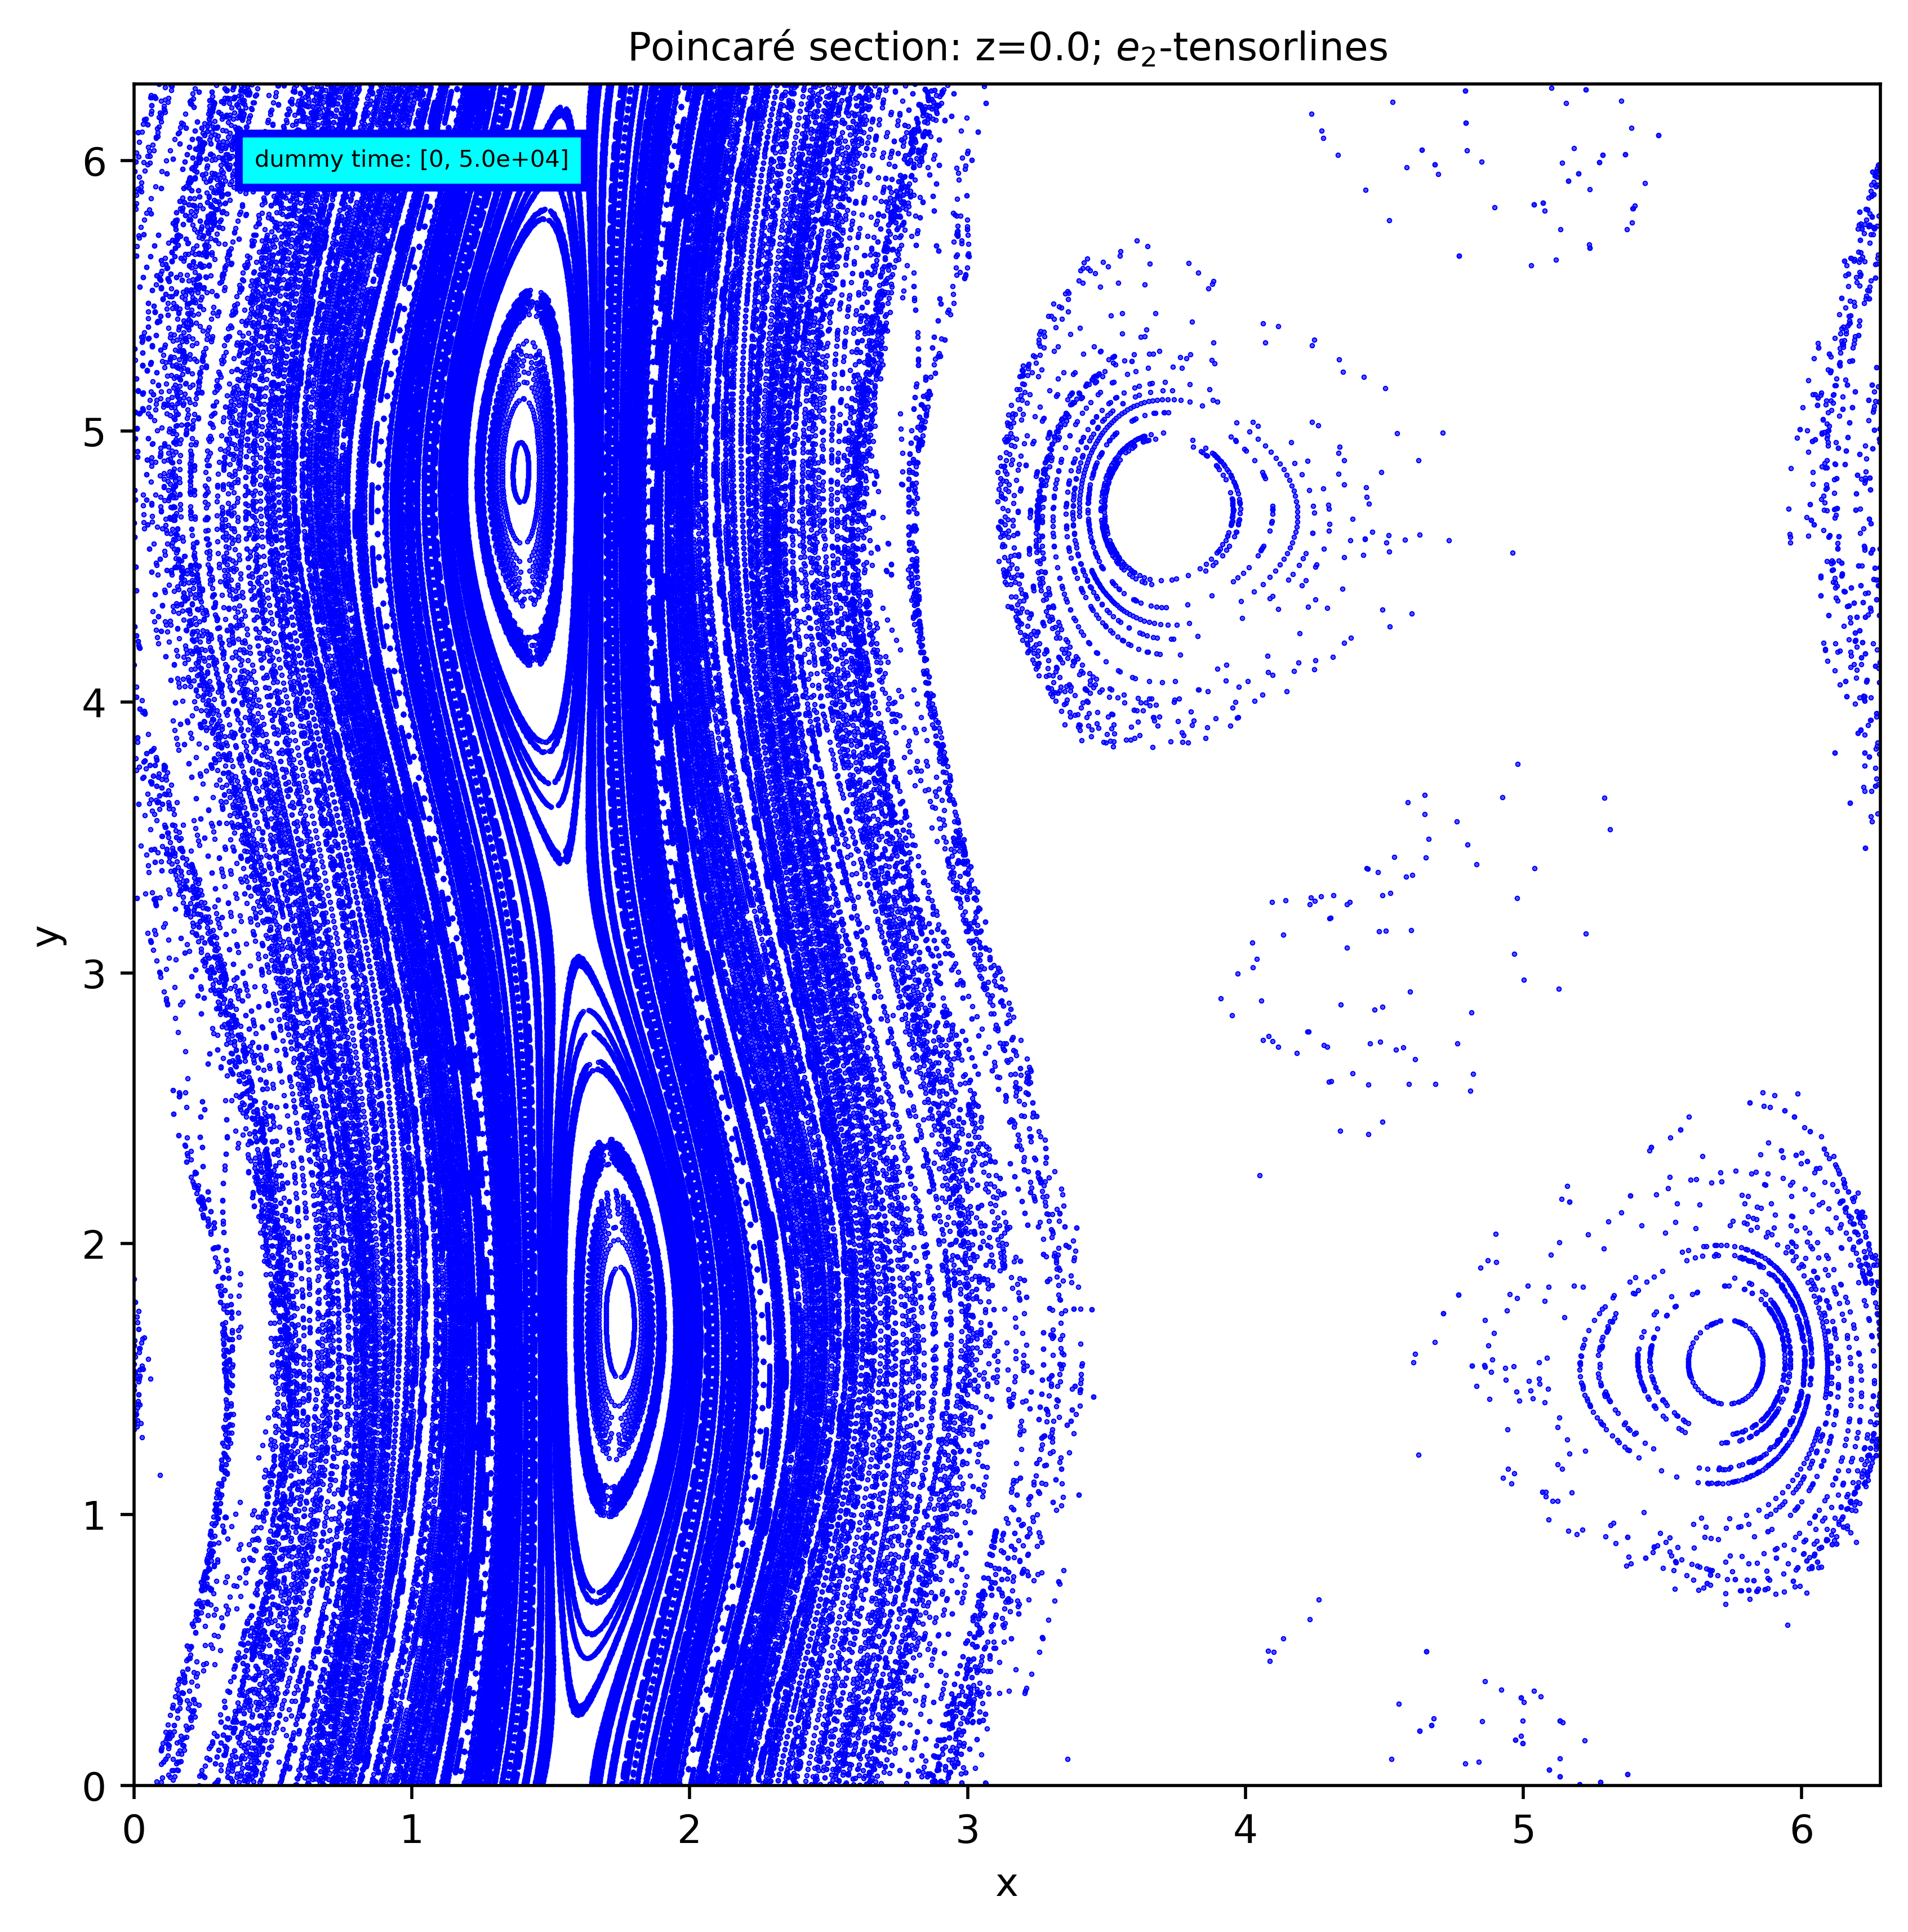

In [11]:
############################################ PLOT RESULTS ############################################

# Import plotting libraries
import matplotlib.pyplot as plt

# Figure/Axes
fig = plt.figure(figsize = (8, 8), dpi=500)
ax = plt.axes()

# Poincare Map
ax.scatter(x_intersec, y_intersec, c = "b", s = .15, marker = "o")

# Axis Label
ax.set_xlabel("x", fontsize = 10)
ax.set_ylabel("y", fontsize = 10)

# Axis limits
ax.set_xlim([0, 2*pi])
ax.set_ylim([0, 2*pi])

ax.text(
    1, 6, f'dummy time: [{int(s_range[0])}, {"{:.1e}".format(np.around(s_range[-1], 0))}]', ha="center", va="center", rotation=0, size=6,
    bbox=dict(fc="cyan", ec="b", lw=2))

# Title
ax.set_title(r'Poincaré section: z='f'{np.around(z0[0], 2)}; '+f'$e_{{{idx_eigenvector+1}}}$'+'-tensorlines', fontsize = 10)

plt.savefig("Poincare_"+f'{np.around(z0[0], 2)}'+"_long_intermediate.jpg", dpi = 500)

plt.show()